### Pair XI
# Decision Tree

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Librerías para la visualización de los datos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Decision Tree en este tipo de problemas. Los objetivos de este pair programming :
- Ajustad un modelo de Decision Tree a nuestros datos.
- Calculad las métricas a nuestro nuevo modelo.
- Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [2]:
df = pd.read_pickle("../data/10_metricas.pkl")
df.head(2)
#df.sample(n = 2000, random_state = 42)


,salario,cesta_compra,bebidas_super,bebidas_rest,comida_rest,ropa,deportes,cine,marlboro,educacion,transporte,gasolina,vehiculos,internet,movil,gastos_fijos,alquiler,m2,inte_fij_hipo,continente_oe
0,586.35,1.602857,3.5475,1.592,10.406667,37.7500,14.77,4.90,4.28,73.76,2.834,1.25,17607.475,7.96,0.01,57.37,319.8075,1844.180,7.96,3
1,1382.83,3.862857,4.3575,2.022,17.230000,77.7925,38.95,8.38,3.49,1356.63,7.880,1.17,19957.900,16.74,0.03,64.76,1537.2925,13253.985,5.01,3


In [3]:
df.duplicated().sum()

0

In [4]:
# Separamos los ejes para comparar nuestra vr con el resto de vp

x = df.drop("salario", axis = 1)
y = df["salario"]

In [5]:
# Creamos el train y test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [6]:
# Creamos el modelo

arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

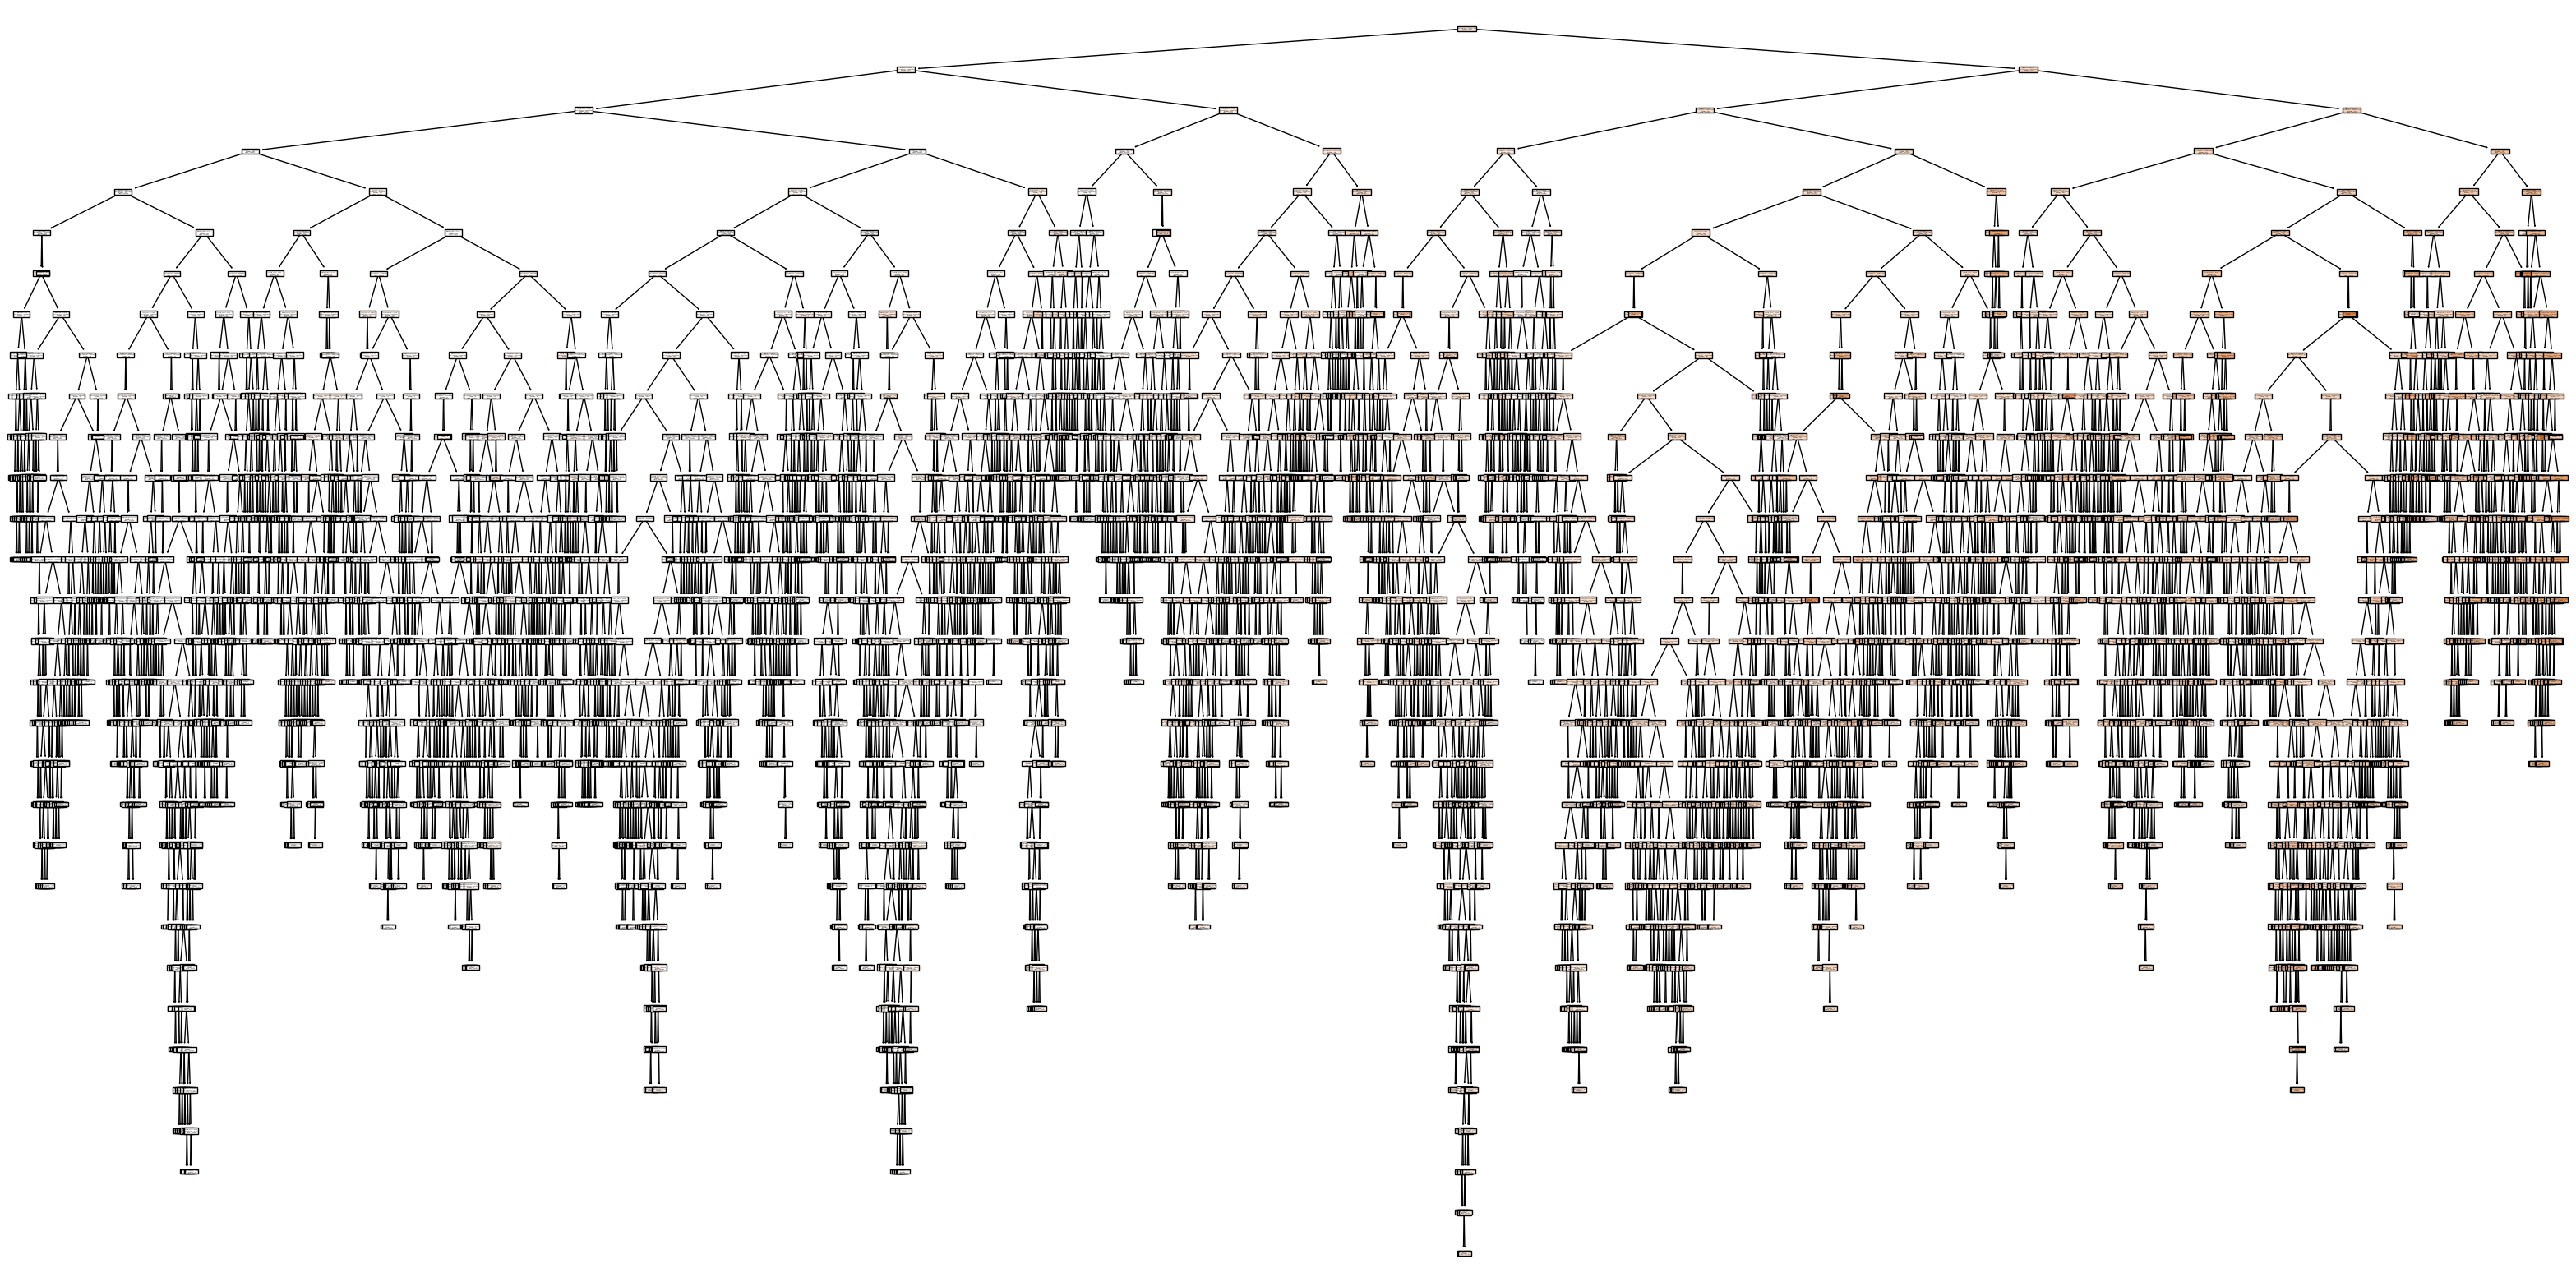

In [7]:
# feature_names = x_train.columns, no funciona, tenemos que pasarle una lista

fig = plt.figure(figsize = (40, 20))
tree.plot_tree(arbol, feature_names = list(x_train.columns), filled = True)
plt.show()

In [8]:
# max features. Como vemos (4 y 5) 

max_features = np.sqrt(len(x_train.columns))
max_features

4.358898943540674

In [9]:
# Dejamos que el modelo decida con max depth 

print(arbol.tree_.max_depth)

30


In [10]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train

y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [11]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [12]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,7.348614e+02,1.419781e+06,1.191545e+03,0.348355,test,Decission Tree I
1,5.938200e-17,1.350190e-29,3.674494e-15,1.000000,train,Decission Tree I


In [13]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [8, 10], # tenemos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 30. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [3, 4, 5],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 3, 4 y 5. Ponemos como límite el 5 ya que el resultado de la raiz cuadrada es 4.2 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [14]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            #verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [15]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [8, 10], 'max_features': [3, 4, 5],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [16]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene:
# Profundidad de 10
# Usa 5 variables predictoras para construir el modelo 
# Tiene min_samples_leaf 50 
# Tiene min_samples_split de 10. 

mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=8, max_features=5, min_samples_leaf=50,
                      min_samples_split=10)

- 2ª comprobación

In [17]:

param = {"max_depth": [10, 15], 
        "max_features": [5, 6], 
        "min_samples_split": [8, 10, 12],
        "min_samples_leaf": [40, 50, 60]} 

In [18]:

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            #verbose=-1, # NOS DA ERROR ¿?
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [19]:

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 15], 'max_features': [5, 6],
                         'min_samples_leaf': [40, 50, 60],
                         'min_samples_split': [8, 10, 12]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [20]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=15, max_features=5, min_samples_leaf=50,
                      min_samples_split=12)

- 3ª comprobación

In [21]:

param = {"max_depth": [10, 11], 
        "max_features": [6, 7], 
        "min_samples_split": [9, 10, 11],
        "min_samples_leaf": [55, 60, 70]} 

In [22]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10,  
            #verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [23]:

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 11], 'max_features': [6, 7],
                         'min_samples_leaf': [55, 60, 70],
                         'min_samples_split': [9, 10, 11]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=11, max_features=7, min_samples_leaf=55,
                      min_samples_split=9)

- 4ª Comprobación

In [25]:

param = {"max_depth": [11], 
        "max_features": [7, 8], 
        "min_samples_split": [11],
        "min_samples_leaf": [54, 55, 56]} 

In [26]:
gs = GridSearchCV( 
            estimator=DecisionTreeRegressor(),
            param_grid= param, 
            cv=10, 
            #verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [27]:

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [11], 'max_features': [7, 8],
                         'min_samples_leaf': [54, 55, 56],
                         'min_samples_split': [11]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=11, max_features=7, min_samples_leaf=56,
                      min_samples_split=11)

- 5ª Comprobación

In [29]:

param = {"max_depth": [11], 
        "max_features": [7], 
        "min_samples_split": [11],
        "min_samples_leaf": [56, 57, 58]} 

In [30]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            #verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [31]:

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [11], 'max_features': [7],
                         'min_samples_leaf': [56, 57, 58],
                         'min_samples_split': [11]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [32]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=11, max_features=7, min_samples_leaf=56,
                      min_samples_split=11)

- 6ª Comprobación

In [33]:

param = {"max_depth": [11], 
        "max_features": [7], 
        "min_samples_split": [11],
        "min_samples_leaf": [56]} 

In [34]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10,  
            #verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [35]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [11], 'max_features': [7],
                         'min_samples_leaf': [56], 'min_samples_split': [11]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [36]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=11, max_features=7, min_samples_leaf=56,
                      min_samples_split=11)

```Gráfica de nuestro árbol de decisión final```

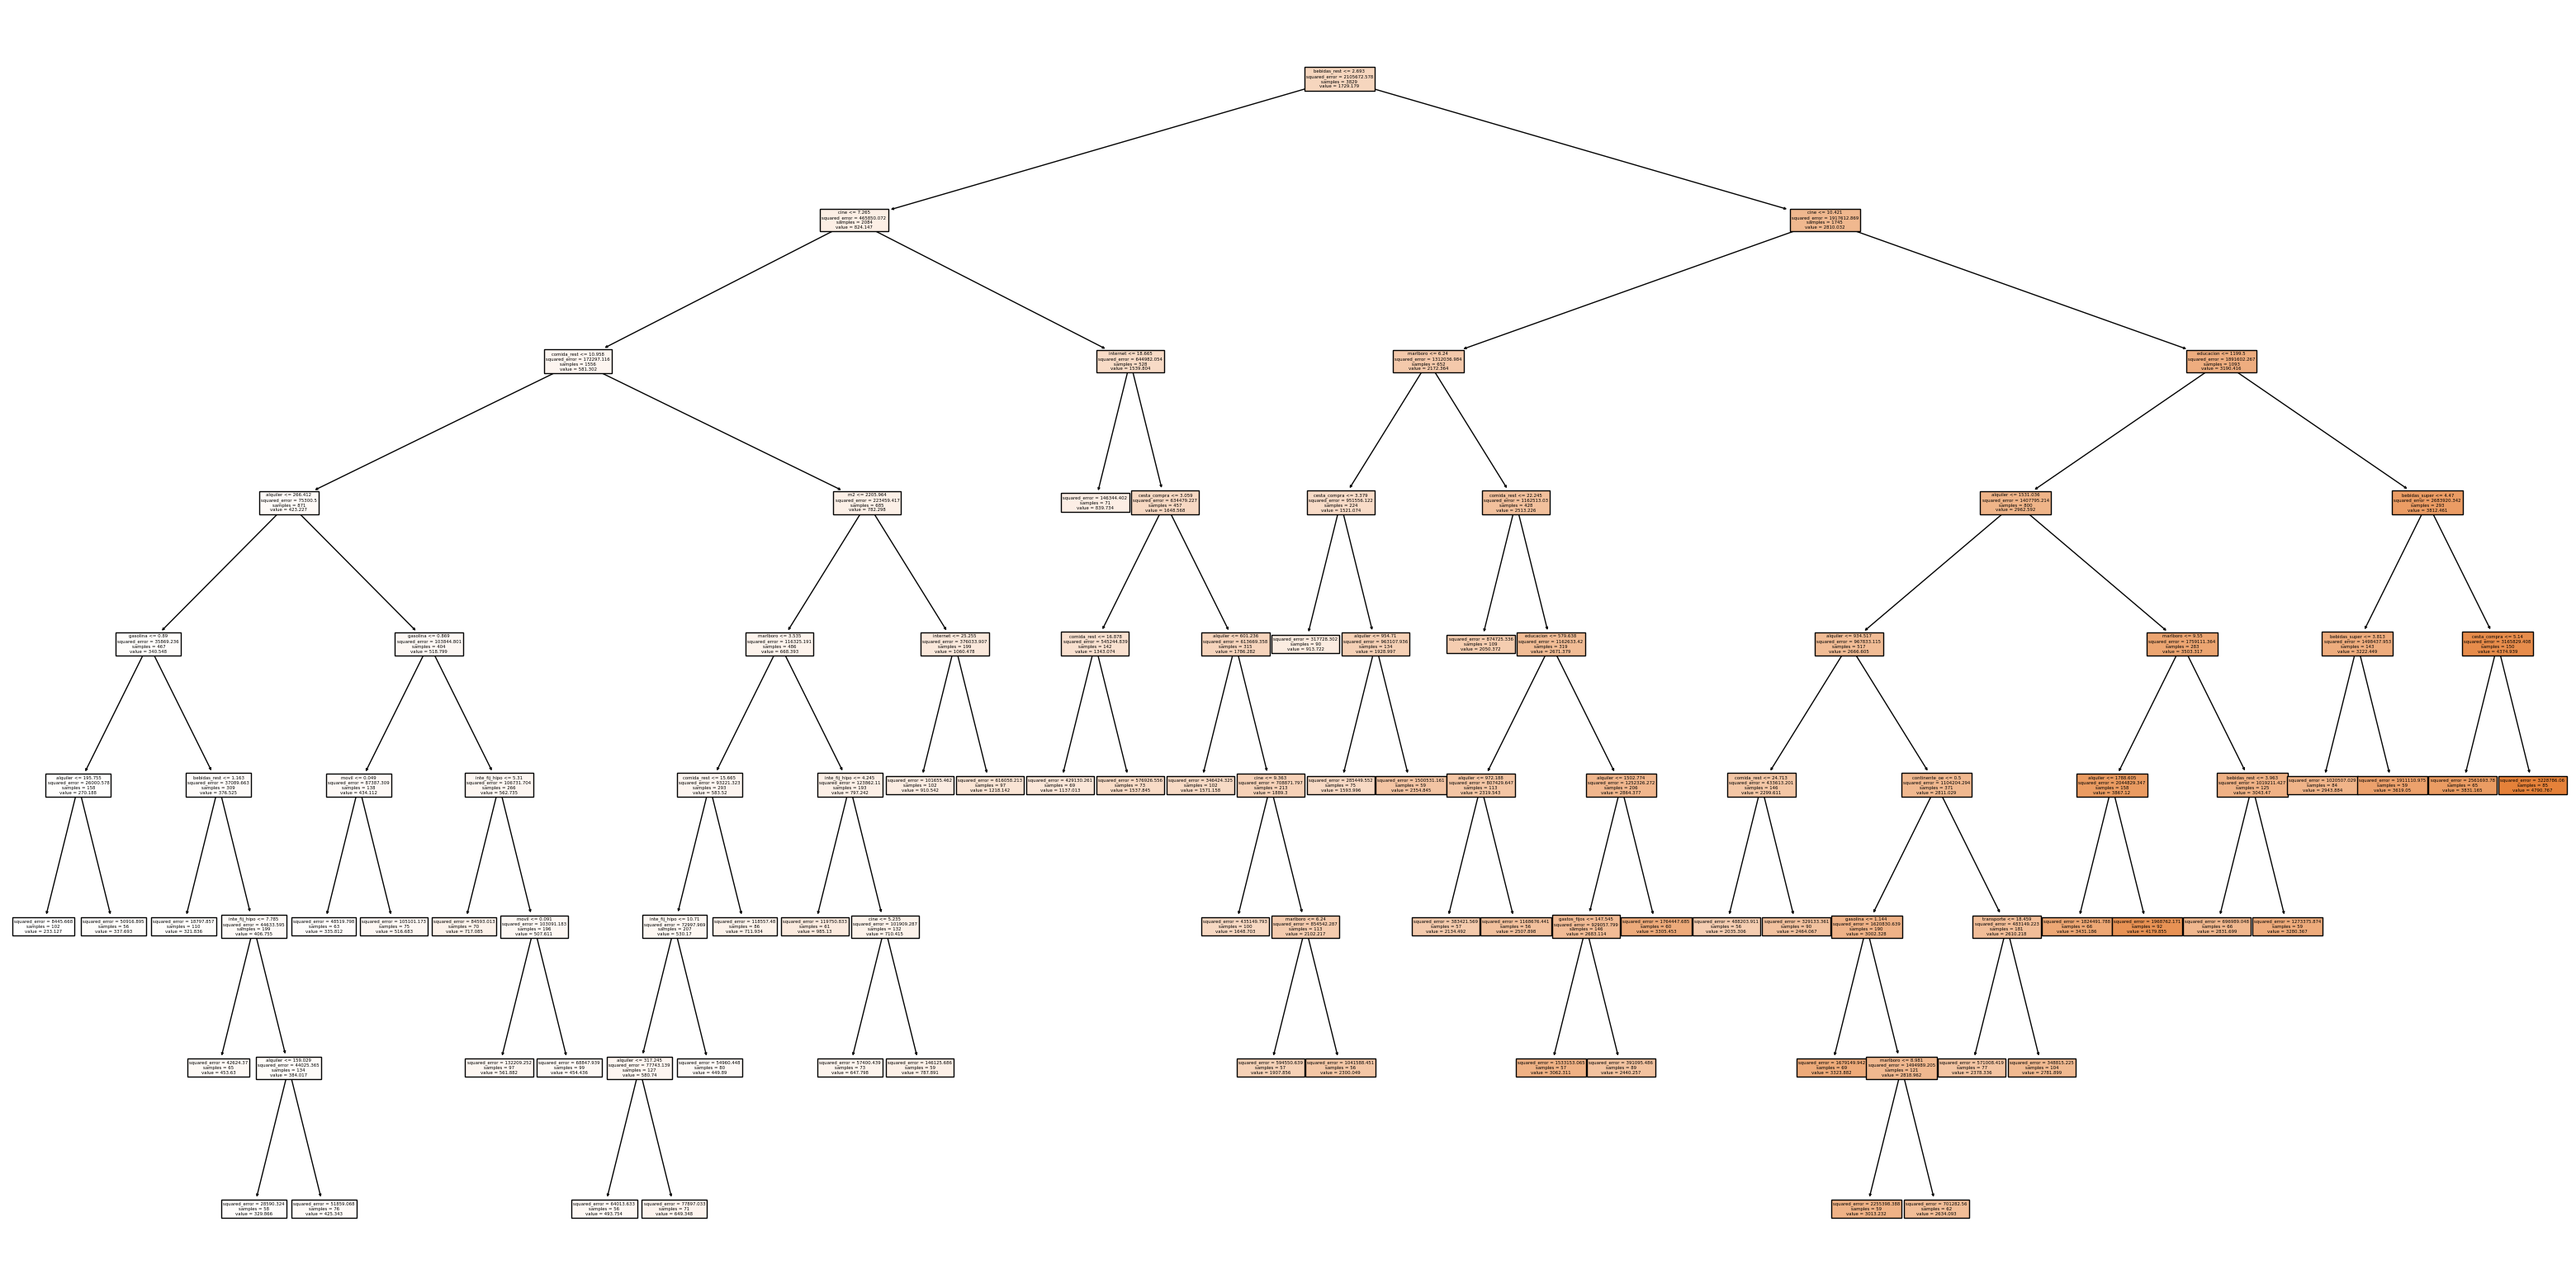

In [37]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names= list(x_train.columns), filled=True)
plt.savefig("../graficas/11_decision_tree.png");

```Cálculo de las métricas del Decision tree VI```

In [38]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [39]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree VI")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,563.482302,866582.345655,930.904048,0.602260,test,Decision tree VI
1,509.724226,642140.661867,801.336797,0.695042,train,Decision tree VI


In [40]:
# Juntamos los dataframes de los resultados de los modelos para poder compararlos mejor

df_results_tree = pd.concat([dt_results1, dt_results2], axis = 0)
df_results_tree

,MAE,MSE,RMSE,R2,set,modelo
0,7.348614e+02,1.419781e+06,1.191545e+03,0.348355,test,Decission Tree I
1,5.938200e-17,1.350190e-29,3.674494e-15,1.000000,train,Decission Tree I
0,5.634823e+02,8.665823e+05,9.309040e+02,0.602260,test,Decision tree VI
1,5.097242e+02,6.421407e+05,8.013368e+02,0.695042,train,Decision tree VI


In [41]:
df_results_tree.to_pickle("../data/df_results_tree.pkl")